# CNNの全体の構造
CNNとは、畳み込みニューラルネットワーク（convolutionalneural network）の略で、画像認識や音声認識など至る所で使われている。CNNではこれまでのニューラルネットワークにさらに「Convolutionレイヤ（畳み込み層）」と「Polingレイヤ（プーリング層）」を組み合わせることで作成できる。
<br>
これまでのニューラルネットワークでは、隣接する層の全てのニューロン間で結合があった。これを**全結合(fully-connected)**と呼び、全結合層をAffineレイヤとして実装した。全結合のニューラルネットワークでは、Affineレイヤの後にReLUレイヤ（またはSigmoidレイヤ）を続けて組み合わせ、最後にSoftmaxレイヤで出力を行う。一方、CNNでは、この全結合ニューラルネットワークのAffine-ReLUという並びをConvolution-ReLU-Poolingという形に置き換える。（Poolingレイヤは省略される場合もある。）また、出力に近い層ではAffine-ReLUが使用され、出力層ではAffine-Softmaxの組み合わせが用いられることが多い。

# 畳み込み層

## 全結合層の問題点
全結合層の問題点は、データの形状が無視されてしまうことである。例えば、入力データが画像の場合には、縦、横、チャンネル方向の3次元のデータが与えられている。しかし、全結合層に入力するときには、このデータを1次元のデータにして入力する必要がある。本来、この3次元というデータの形状は、それ自体が情報を持つことが多い。よって全結合層ではこの情報を生かし切れない。
一方で、CNNではデータの形状を維持するため、画像などの形状を有するデータを正しく学習できる可能性がある。なお、CNNでは畳み込み層の入出力データを**特徴マップ（feature map）**と言う場合があり、畳み込み層の入力データを**入力特徴マップ（input feature map）**、出力データを**出力特徴マップ（output feature map）**と言う。

## 畳み込み演算
畳み込み層では、「畳み込み演算」を行う。これは、画像処理で言う「フィルター演算」にあたる。この演算では、以下の画像のように、フィルターをずらしながら積和計算を行っていく。
<img src='https://s3-ap-northeast-1.amazonaws.com/dragonarrow/uploads%2F1565688214362-ConvolutionCaluculationFlow.png'>
CNNでは、このフィルターの値が重みパラメータとなる。また、バイアスは常に1×1の形状で存在しており。フィルター適用後の全ての要素に加算される。また、この図の奥行きがある場合を考えることで、3次元の畳み込み演算についても考えることができる。

## パディング
畳み込み層の処理の前に、入力データの周囲に0などの固定のデータを埋めることがあり、それを**パディング**と言う。これは、出力サイズを調整するために用いられる。もし畳み込み演算を行う度にデータのサイズが縮小されてしまうと、ある時点でサイズが1になってしまい、それ以上演算をできなくなってしまう。

## ストライド
フィルターを適用する位置の間隔を、**ストライド（stride）**という。入力サイズを$(H,W)$、フィルターサイズを$(FH,FW)$、出力サイズを$(OH,OW)$、パディングを$P$、ストライドを$S$とおくと、出力サイズは以下のように計算できる。<br>
$\displaystyle{
OH = \frac{H+2P-FH}{S}+1 \\
OW = \frac{W+2P-FH}{S}+1
}$
<br>
注意すべき点としては、この式が割り切れるような値を設定しなければならないということである。フレームワークによっては、割り切れないときは最も近い整数に丸める処理を行ったりする。

## バッチ処理
畳み込み演算においても、バッチ処理を使用することができる。各層を流れるデータを(batch_num, channel, height, width)といった順番の4次元のデータとする。このとき、(N,C,H,W)といった形のN個の入力データは、(FN,C,FH,FW)といった形のフィルターを経て、(N,FN,OH,W)というデータになり、(FN,1,1)のバイアスを加算することで出力データとなる。このとき、N個のデータがまとめてバッチとして畳み込み演算されている。

# プーリング層
プーリングは、縦・横方向の空間を小さくする演算。
<img src='https://s3-ap-northeast-1.amazonaws.com/dragonarrow/uploads%2F1565693901156-pooling.png'>
この画像は、2×2のMaxプーリングをストライド2で行っている例。Maxプーリングは、指定範囲内の最大値をとる演算で、ほかにも平均をとるAverageプーリングがある。画像認識の分野では主にMaxプーリングが使用される。

## プーリング層の特徴
プーリング層の特徴として、以下の3つがある。
1. 学習するパラメータがない
1. チャンネル数は変化しない
    - チャンネルごとに独立して計算が行われるため、チャンネル数は変化しない。
1. 微小な位置変化に対してロバスト（頑健）
    - 入力データの小さなズレに対して、プーリングはズレを吸収することが多い。

# Convolution/Poolingレイヤの実装
ここでは、以前に誤差逆伝播法を実装した際と同じように、```forward```と```backward```というメソッドを持たせ、モジュールの形で実装する。

## 4次元配列
CNNでは、各層を4次元のデータが流れる。例えば、(10,1,28,28)という形状のデータは、高さ28、横幅28、1チャンネルで10個のデータを表す。pythonでは、以下のようにnumpy配列で4次元配列を定義することでこのような形のデータを作ることができる。

In [2]:
import numpy as np

x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

## im2colによる展開
Numpyでは演算速度の観点から、for文は非推奨とされている。そのため、im2colという関数を使用する。im2colは、フィルターにとって都合のいいように入力データを展開する。具体的には、3次元（正確にはバッチ数を含めた4次元）の入力データを、2次元の行列へと展開する。展開した後は、フィルターも1列に展開して、2つの行列の積を計算して出力データのサイズに整形する。

## Convolutionレイヤの実装
ここで使用する```im2col```という関数は、以下のインタフェースを持つ。
<br>
<br>
```im2col(input_data, filter_h, filter_w, stride=1, pad=0)```

- ```input_data``` （データ数,チャンネル,高さ,横幅）の4次元配列からなる入力データ
- ```filter_h``` フィルターの高さ
- ```stride``` ストライド
- ```pad``` パディング

<br>
この関数を使用して畳み込み層をConlvolutionという名前のクラスで実装したのが以下である。

In [4]:
from common.util import im2col

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

## Poolingレイヤの実装
Poolingレイヤの実装に関しては、チャンネルごとに独立していることから、プーリングの適用領域をim2colで展開し、同様に行列計算に持ち込む。以下がPoolingレイヤの実装である。

In [5]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# CNNの実装
2つのレイヤの実装が完了したため、実際に手書き文字認識を行うCNNをSimpleConvNetという名前のクラスで実装してみる。これは、以下の引数を取るものとする。<br>

- input_dim ―― 入力データの (チャンネル, 高さ, 幅) の次元
- conv_param ―― 畳み込み層のハイパーパラメータ(ディクショナリ)。ディクショナリのキーは下記のとおり
    - filter_num ―― フィルターの数 

    - filter_size ―― フィルターのサイズ

    - stride ―― ストライド 

    - pad ―― パディング 

- hidden_size ―― 隠れ層(全結合)のニューロンの数
- output_size ―― 出力層(全結合)のニューロンの数
- weight_init_std ―― 初期化の際の重みの標準偏差

<br>
実装は下記。

In [12]:
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    """単純なConvNet

    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

このCNNネットワークを用いてMNISTデータセットを学習したのが以下のコード。

train loss:2.2993041560423055
=== epoch:1, train acc:0.161, test acc:0.176 ===
train loss:2.297909009309171
train loss:2.2949591099473405
train loss:2.2887315801366004
train loss:2.2796434606496403
train loss:2.2704794309933307
train loss:2.254400130940676
train loss:2.2398239774232884
train loss:2.215239001981079
train loss:2.1949568027211908
train loss:2.169835059230362
train loss:2.1381118363928224
train loss:2.1023176158151884
train loss:2.0749559832132634
train loss:1.9902079906496706
train loss:1.9949707549804492
train loss:1.8318747080182889
train loss:1.8689428671616153
train loss:1.8596137602909228
train loss:1.7140818473921595
train loss:1.6705747612233077
train loss:1.5696225168744737
train loss:1.502527169960635
train loss:1.419303321458336
train loss:1.3458605009056348
train loss:1.1319073110816376
train loss:1.2897557445324295
train loss:1.078606653117976
train loss:1.1292775184166643
train loss:1.0992097599305082
train loss:0.9557279827807175
train loss:0.769765881004001

train loss:0.28049385904828134
train loss:0.20319388613662073
train loss:0.18855575460011612
train loss:0.3126087831136989
train loss:0.2015827568911306
train loss:0.25502807364327745
train loss:0.16653425185598816
train loss:0.18169107083228686
train loss:0.22370475934372366
train loss:0.19725778690616314
train loss:0.22816265441472694
train loss:0.26023040367127687
train loss:0.23468586633600355
train loss:0.2518394699035678
train loss:0.3261952601742461
train loss:0.32911142951724714
train loss:0.1450668432761913
train loss:0.2242813707487117
train loss:0.30378228471944857
train loss:0.25393645406955284
train loss:0.18458275556994821
train loss:0.3281167741374992
train loss:0.43057948276973845
train loss:0.3674064810058807
train loss:0.1849062442707893
train loss:0.3010198302453827
train loss:0.35334438517480876
train loss:0.2596776663819139
train loss:0.19027172262290415
train loss:0.14261108870274794
train loss:0.22554735913664953
train loss:0.18451418119810867
train loss:0.268567

train loss:0.1185735528873793
train loss:0.19620187738042888
train loss:0.11980145379812278
train loss:0.09289199909299004
train loss:0.3297404487367902
train loss:0.09651721801068536
train loss:0.14499856704260855
train loss:0.19817660179820984
train loss:0.21975132971476938
train loss:0.11039950752550323
train loss:0.1266275997296851
train loss:0.14636962882696178
train loss:0.14496877479326187
train loss:0.1852088378323651
train loss:0.13929001172803157
train loss:0.13853990082549156
train loss:0.15675599861018247
train loss:0.1912110070010608
train loss:0.29583660128872347
train loss:0.130796184694573
train loss:0.23921047689677333
train loss:0.29498214369079506
train loss:0.19500230759845205
train loss:0.1649400958170583
train loss:0.15926872105155565
train loss:0.17285004080657282
train loss:0.11366648177083777
train loss:0.09792621893117642
train loss:0.1994528175303309
train loss:0.07286817805319283
train loss:0.18275826209476023
train loss:0.13322278306062985
train loss:0.1535

train loss:0.11256830703902622
train loss:0.05543183913177554
train loss:0.09898862716731242
train loss:0.16418783316035315
train loss:0.11295825595011989
train loss:0.11813290959877946
train loss:0.17907553264511958
train loss:0.11731770024113632
train loss:0.15221432898662599
train loss:0.1582354903492018
train loss:0.08145895892743345
train loss:0.07822949345132373
train loss:0.054079120055556915
train loss:0.06782807997983617
train loss:0.12538704820545332
train loss:0.03231716406884286
train loss:0.1468728723253658
train loss:0.09071391992464138
train loss:0.08923776128109777
train loss:0.06404701034687492
train loss:0.05708191819402328
train loss:0.05975544161018798
train loss:0.16326455028744735
train loss:0.13754115744586193
train loss:0.03471197492016099
train loss:0.05189356994554514
train loss:0.11258693934971348
train loss:0.09925946670944416
train loss:0.08874486141845633
train loss:0.09578750094004454
train loss:0.09034237215563777
train loss:0.020774927751932862
train lo

train loss:0.09918434262158782
train loss:0.020821382318473663
train loss:0.04849263756722185
train loss:0.03928761115106956
train loss:0.07854568834653644
train loss:0.08169115682957169
train loss:0.04267909635065403
train loss:0.09377610898393098
train loss:0.0666806477369286
train loss:0.0849910749749128
train loss:0.15833182027399817
train loss:0.08031356058670953
train loss:0.05219875675555052
train loss:0.19087890353211823
train loss:0.11309524043464812
train loss:0.09300176050899314
train loss:0.05675467960825186
train loss:0.025017554750870762
train loss:0.11694666350990275
train loss:0.048619827993676576
train loss:0.04451772046694358
train loss:0.08667769523814652
train loss:0.056749973948215605
train loss:0.11063180922577448
train loss:0.12429970258073574
train loss:0.10378205664648607
train loss:0.1072692479558852
train loss:0.1770898825460898
train loss:0.05234439548035968
train loss:0.06770717626493004
train loss:0.12207485305670263
train loss:0.05162291299161134
train lo

train loss:0.12388629018728915
train loss:0.04769396917603937
train loss:0.09059190632973257
train loss:0.06088484960250242
train loss:0.014898938881111094
train loss:0.08450227984186542
train loss:0.07374140602367187
train loss:0.029154169098124957
train loss:0.06680709264992109
train loss:0.02977103443035916
train loss:0.04564433486568619
train loss:0.07442249529624516
train loss:0.05602756536709983
train loss:0.05167848229162348
train loss:0.062030454670415625
train loss:0.06468301617133049
train loss:0.1360497515565252
train loss:0.05201305060352188
train loss:0.03886023715887319
train loss:0.06553169628744007
train loss:0.20007142940811193
train loss:0.06686161661000989
train loss:0.024106874042089648
train loss:0.04547863531633872
train loss:0.011592424546612105
train loss:0.030526307219647685
train loss:0.032836248122632014
train loss:0.11078551549200145
train loss:0.04406689310396142
train loss:0.10284791738579296
train loss:0.05428841747648669
train loss:0.07877770023470218
tr

train loss:0.1357984097301195
train loss:0.07063124381688231
train loss:0.05400285329644814
train loss:0.07636459828212822
train loss:0.061527824444361424
train loss:0.032532226112124
train loss:0.05120381695979349
train loss:0.06409641569790997
train loss:0.24029479376026125
train loss:0.023537200978528926
train loss:0.00999033878894101
train loss:0.04449964105507708
train loss:0.03310508049324294
train loss:0.06512568061082187
train loss:0.0561573148013712
train loss:0.08443428160153968
train loss:0.10734376614384492
train loss:0.03750661787691026
train loss:0.03585029254035079
train loss:0.02654098504758361
train loss:0.020494911684684362
train loss:0.057254522580931805
train loss:0.04879734957056879
train loss:0.1078048913785279
train loss:0.04183058769025064
train loss:0.030345158917952718
train loss:0.055981813510696234
train loss:0.10307344193213348
train loss:0.03400133093495653
train loss:0.06375432024878633
train loss:0.035934338822243846
train loss:0.04151433453964306
train 

train loss:0.018923468324431984
train loss:0.03245375010609859
train loss:0.11600632924053363
train loss:0.03166660567531376
train loss:0.032655351611160933
train loss:0.056768899023185215
train loss:0.0497652458471623
train loss:0.043412471294005585
train loss:0.015490020445072961
train loss:0.07748199931499156
train loss:0.02637293651821007
train loss:0.08620462625928131
train loss:0.05048933578038404
train loss:0.06236344324620138
train loss:0.021666327286596804
train loss:0.06328485528076168
train loss:0.04236456206919966
train loss:0.01722839909217017
train loss:0.04982937732543473
train loss:0.03445262949439039
train loss:0.017666791838255366
train loss:0.041480067628636264
train loss:0.05620819120556046
train loss:0.028502057386272137
train loss:0.03600015493734985
train loss:0.011287306292295105
train loss:0.04817415350616718
train loss:0.03318573434043943
train loss:0.06389059415491456
train loss:0.04056489190505955
train loss:0.03700131560802464
train loss:0.00723660587602596

train loss:0.11096944045042317
train loss:0.05244527468847659
train loss:0.05049708015621721
train loss:0.03216343235187092
train loss:0.04182523149416217
train loss:0.023126557718239554
train loss:0.06350464335446257
train loss:0.036215944438885296
train loss:0.06807444850728
train loss:0.05795214754321435
train loss:0.06447208280720566
train loss:0.02613702158823754
train loss:0.1011328942038738
train loss:0.047784286863993095
train loss:0.015342277325607064
train loss:0.049759847313968555
train loss:0.02272783473865566
train loss:0.025145368295753038
train loss:0.012774627041587267
train loss:0.0416859684820561
train loss:0.023930264300175693
train loss:0.035269038368110864
train loss:0.06473285374872106
train loss:0.11459765231592192
train loss:0.044052361941622424
train loss:0.018312094249786495
train loss:0.029782232665059485
train loss:0.08086373080114867
train loss:0.02904832543816531
train loss:0.11346256585318294
train loss:0.06338020771222448
train loss:0.08249016994098594
t

train loss:0.01290133566355204
train loss:0.013450575759883787
train loss:0.05721827248586951
train loss:0.04141210778133197
train loss:0.014781063442322774
train loss:0.017280286718775757
train loss:0.011641543737482577
train loss:0.03137124148306077
train loss:0.0596379135434721
train loss:0.03261978390262075
train loss:0.04234830459483835
train loss:0.015205932036303358
train loss:0.05868883900605899
train loss:0.04507954594641717
train loss:0.02932670169844718
train loss:0.12616597343593017
train loss:0.027586579937915513
train loss:0.03793197421286948
train loss:0.03757629576192492
=== epoch:5, train acc:0.982, test acc:0.988 ===
train loss:0.03441886603586832
train loss:0.059116811643427136
train loss:0.0447964845436103
train loss:0.010495882271599685
train loss:0.04647199548453147
train loss:0.04611305313604061
train loss:0.09476520878053002
train loss:0.022839032475687093
train loss:0.03692495773903948
train loss:0.0264740422781269
train loss:0.02300567150768067
train loss:0.07

train loss:0.004061575409485057
train loss:0.025474096720297296
train loss:0.0351033938725896
train loss:0.04454768248614987
train loss:0.025980290654554105
train loss:0.010981025796663935
train loss:0.04799710423393586
train loss:0.021833595530387506
train loss:0.013310762062828132
train loss:0.041931075799759326
train loss:0.015475329268632215
train loss:0.007750005678831494
train loss:0.025695620128785367
train loss:0.06998430155674157
train loss:0.03025259870693989
train loss:0.010274144713251077
train loss:0.0857699317773219
train loss:0.016852453020068197
train loss:0.0744818503939849
train loss:0.022324334751422644
train loss:0.018447515341453325
train loss:0.019942198280996144
train loss:0.06390352453289493
train loss:0.017241021719430455
train loss:0.04818178334799121
train loss:0.05762171895226574
train loss:0.03668760362768928
train loss:0.009479507948493207
train loss:0.027736930566165774
train loss:0.08839318835050265
train loss:0.026156536653779344
train loss:0.0404482602

train loss:0.015605685831996919
train loss:0.0264684512660385
train loss:0.02336781663410706
train loss:0.011004611059895466
train loss:0.021422219244417645
train loss:0.03602695404819679
train loss:0.023269971659890757
train loss:0.020122201205403666
train loss:0.0343544351692218
train loss:0.01755854655800791
train loss:0.042585457156331524
train loss:0.018931672464304102
train loss:0.03163497856606874
train loss:0.012625982586666395
train loss:0.02557206396716243
train loss:0.051437279865053774
train loss:0.018725677756113637
train loss:0.015713538100905835
train loss:0.034553554504082616
train loss:0.05757702849769573
train loss:0.031199724784562538
train loss:0.006086923911766802
train loss:0.017654841046800613
train loss:0.10763918570656746
train loss:0.051286389502109654
train loss:0.015158515256103422
train loss:0.04274899292104461
train loss:0.07715032259481418
train loss:0.013798106009437752
train loss:0.03147222084562551
train loss:0.013316672393142244
train loss:0.007734371

train loss:0.011526581345386368
train loss:0.02503380157223672
train loss:0.039201457829751624
train loss:0.015934628504494803
train loss:0.012941782946856247
train loss:0.03721461905794248
train loss:0.09441787377225394
train loss:0.011143936648100521
train loss:0.02885711377170313
train loss:0.012848545753469373
train loss:0.01579448986350258
train loss:0.0301365658402406
train loss:0.037655010885946895
train loss:0.029495667594738432
train loss:0.015154140871256862
train loss:0.009234417950505818
train loss:0.007990963352978957
train loss:0.06781420512857532
train loss:0.037878446246850356
train loss:0.009674065235273534
train loss:0.008912175146421439
train loss:0.0058399864653635
train loss:0.02427905952117608
train loss:0.0030822402585606277
train loss:0.026613899496814045
train loss:0.011365192917106012
train loss:0.012339498764078756
train loss:0.04681329931836127
train loss:0.016399877668546926
train loss:0.01634969063693947
train loss:0.016562702832556765
train loss:0.0275997

train loss:0.009828206082710214
train loss:0.014842452652653278
train loss:0.006874268824366199
train loss:0.005472986658873678
train loss:0.06029793449805093
train loss:0.0096573208417218
train loss:0.11645526369593708
train loss:0.015919578621410885
train loss:0.16081971150026875
train loss:0.009696602099093345
train loss:0.08895885324989339
train loss:0.033216408949373485
train loss:0.009800144117308956
train loss:0.003410750034398991
train loss:0.044330069065241444
train loss:0.025044814400732692
train loss:0.006245466266146594
train loss:0.027444655905330025
train loss:0.027098108480654092
train loss:0.01831203065676404
train loss:0.020871754348546764
train loss:0.04011967536741638
train loss:0.00567078118753717
train loss:0.018693600688025357
train loss:0.04093564725719437
train loss:0.03509186830118815
train loss:0.021432257054288927
train loss:0.07259257132651264
train loss:0.025545882954976794
train loss:0.014585358584449211
train loss:0.0793798748118613
train loss:0.026385068

train loss:0.04097114829436871
train loss:0.04393833931458158
train loss:0.005006531942799138
train loss:0.027579456131820314
train loss:0.03061462494414307
train loss:0.003101260825482732
train loss:0.003998334066427071
train loss:0.06376498881492348
train loss:0.01775436589900202
train loss:0.006025355354374773
train loss:0.004659711110145284
train loss:0.002649614524600199
train loss:0.028289843088451776
train loss:0.019568256569891994
train loss:0.01775363101473923
train loss:0.044188273520897076
train loss:0.07732454428871245
train loss:0.026843491916101025
train loss:0.016089625067318866
train loss:0.011468934136518345
train loss:0.010356761688788216
train loss:0.01681481718252645
train loss:0.0037311549101158984
train loss:0.022695859401149564
train loss:0.015215972534703567
train loss:0.0030362014550306556
train loss:0.0025463876054887813
train loss:0.0044373646541152455
train loss:0.05378788548516946
train loss:0.013146686399165325
train loss:0.007378894398414597
train loss:0.

train loss:0.007999633489846754
train loss:0.006063720618276214
train loss:0.008218190949205088
train loss:0.019315477728866996
train loss:0.0036015759507241445
train loss:0.04536517897331124
train loss:0.03600427155656575
train loss:0.02403176670568235
train loss:0.006143335914286292
train loss:0.015971848238313754
train loss:0.023110834788370404
train loss:0.008365847677770811
train loss:0.02419423811393814
train loss:0.08629376223086219
train loss:0.006505127664885386
train loss:0.028965635341381527
train loss:0.0032921760025534947
train loss:0.005487071155404022
train loss:0.06262069565769139
train loss:0.010893259026911043
train loss:0.0018913441637587944
train loss:0.015863508882188525
train loss:0.01764022248353629
train loss:0.016039285632463384
train loss:0.017401315798141723
train loss:0.01089493006537798
train loss:0.07362282386591651
train loss:0.01302755852807512
train loss:0.0426168947158408
train loss:0.030802638884208658
train loss:0.020272132308306507
train loss:0.0466

train loss:0.007993523657863542
train loss:0.01254910144245242
train loss:0.009636883555659437
train loss:0.03704658675075589
train loss:0.036088359584883656
train loss:0.029573585509511634
=== epoch:8, train acc:0.991, test acc:0.985 ===
train loss:0.007086054443274878
train loss:0.006213347348400159
train loss:0.011117621240093089
train loss:0.010058125305689234
train loss:0.004317393948999456
train loss:0.019978254694733293
train loss:0.007342524175000761
train loss:0.008906547090584584
train loss:0.0014250258759782059
train loss:0.009137886893546195
train loss:0.0169989825186879
train loss:0.007924553014682471
train loss:0.011575560536497671
train loss:0.024980605515303563
train loss:0.0022840393504732623
train loss:0.010095490569319951
train loss:0.03996275354348362
train loss:0.011645979612571739
train loss:0.029071944377696703
train loss:0.015934065583666883
train loss:0.07324673980891887
train loss:0.019393180827790193
train loss:0.04162706846169153
train loss:0.008126673179720

train loss:0.018801346598585778
train loss:0.006676982525494358
train loss:0.03558215246279155
train loss:0.007358643353844187
train loss:0.007855641901914916
train loss:0.0077176723587587285
train loss:0.011883708064840029
train loss:0.011837978679469556
train loss:0.0188335118542356
train loss:0.013712050680086645
train loss:0.005332492350135456
train loss:0.03710684526723412
train loss:0.02180967180376531
train loss:0.0019602849601142924
train loss:0.017508050680557333
train loss:0.01680642064821531
train loss:0.012552325677335193
train loss:0.009607462189411126
train loss:0.011812515647885739
train loss:0.03836957152626253
train loss:0.007138435846980956
train loss:0.0795975630853493
train loss:0.013804255302783737
train loss:0.007505387568175703
train loss:0.007696312060392482
train loss:0.008564818407036795
train loss:0.011216907896740087
train loss:0.031221242462549773
train loss:0.018045611077468948
train loss:0.00930656410775067
train loss:0.000839994731454133
train loss:0.010

train loss:0.00828577673987146
train loss:0.0033192613108113072
train loss:0.014912454571231692
train loss:0.015816225412512312
train loss:0.0014644862883664924
train loss:0.004016033126831118
train loss:0.007352070803264633
train loss:0.026886822125706436
train loss:0.005761927157297495
train loss:0.003856812245131166
train loss:0.01786740353390814
train loss:0.05061375854097459
train loss:0.011039473401754098
train loss:0.022079351148938137
train loss:0.011634392345977069
train loss:0.002912197431814222
train loss:0.005183763268969826
train loss:0.017392233625678058
train loss:0.03601493185418084
train loss:0.008053347432466705
train loss:0.0036595401982944397
train loss:0.007504586861043876
train loss:0.003360614354522812
train loss:0.043760116200139275
train loss:0.0188095256768335
train loss:0.002847442403617942
train loss:0.005894658613056592
train loss:0.00348389190966698
train loss:0.008023973521605512
train loss:0.013265906689300989
train loss:0.019246795716624767
train loss:0

train loss:0.005474895292374394
train loss:0.0035499473260114044
train loss:0.008239750307808895
train loss:0.02144647014210419
train loss:0.012173945013551119
train loss:0.012674902435242393
train loss:0.003459688557581153
train loss:0.004238094954547894
train loss:0.016852179558296605
train loss:0.0010871330433866984
train loss:0.0015546953966135105
train loss:0.004001938127484535
train loss:0.003499961418593242
train loss:0.007401317718250148
train loss:0.012895083436362819
train loss:0.003330340332954439
train loss:0.004209056646007775
train loss:0.003326226544850161
train loss:0.002122979584909499
train loss:0.007202364355652955
train loss:0.009354218524692506
train loss:0.011206074769466001
train loss:0.011203981514512842
train loss:0.006501393102572404
train loss:0.007536633516074357
train loss:0.01593618357144485
train loss:0.013775164095020638
train loss:0.010085786232993584
train loss:0.03665792812090765
train loss:0.01554958611792455
train loss:0.07565767981123937
train loss

train loss:0.0035061301232521837
train loss:0.00844328628712056
train loss:0.0219872165706762
train loss:0.06750222944607631
train loss:0.003416061636633145
train loss:0.005802028502217267
train loss:0.0036597045858895953
train loss:0.001187364494648591
train loss:0.006244568328672348
train loss:0.0108994145019313
train loss:0.005608814115955795
train loss:0.02348497333050203
train loss:0.003472041987939083
train loss:0.003824825935500764
train loss:0.009873846999480377
train loss:0.0063533821449306225
train loss:0.0013051594021675293
train loss:0.008371931838971143
train loss:0.004040946444184071
train loss:0.004749285749596353
train loss:0.04402889512616224
train loss:0.03630149200247183
train loss:0.0021089170181708035
train loss:0.004505756472800258
train loss:0.00833043913742258
train loss:0.00436691802477496
train loss:0.021829154598125924
train loss:0.016793225323337546
train loss:0.0015351357157346052
train loss:0.020630746040086696
train loss:0.022697423010643137
train loss:0.

train loss:0.08225538296392816
train loss:0.012759067618569238
train loss:0.004662001273007559
train loss:0.01407126412444078
train loss:0.00897937231070361
train loss:0.004518103084217621
train loss:0.0040442794755732895
train loss:0.005866553242521625
train loss:0.0008764906454928944
train loss:0.009090608109251882
train loss:0.0005510769740351754
train loss:0.004492159207355577
train loss:0.006500534088138281
train loss:0.021141049158282865
train loss:0.05223484178986773
train loss:0.004399026270191768
train loss:0.001606484812791269
train loss:0.0032494833906646647
train loss:0.0008201427608236127
train loss:0.017146161938166527
train loss:0.012805360633484504
train loss:0.002915347089155689
train loss:0.011327944422950815
train loss:0.0038316775941021025
train loss:0.008082621530251306
train loss:0.00905199762820479
train loss:0.02230415380582045
train loss:0.003226591993749231
train loss:0.0036443389948718143
train loss:0.014391301345877284
train loss:0.003246647236340428
train l

train loss:0.012079250304163756
train loss:0.010788770634588718
train loss:0.02199631313662591
train loss:0.0038600927434010294
train loss:0.008918176000829748
train loss:0.008674257139129525
train loss:0.03261465077767374
train loss:0.012115444015974773
train loss:0.00713071811314418
train loss:0.0012363159213723792
train loss:0.02131046192931434
train loss:0.008438003821108585
train loss:0.02974355915174211
train loss:0.012270329698585688
train loss:0.003546258018240445
train loss:0.004794265280531552
train loss:0.0014846889794897324
train loss:0.005436098365542062
train loss:0.009150179795389334
train loss:0.045139043415100326
train loss:0.0086202824492236
train loss:0.004563874314001605
train loss:0.02078921717595552
train loss:0.009386729753629065
train loss:0.005902720322337395
train loss:0.0007456522405769647
train loss:0.001500356046451145
train loss:0.013329226372240979
train loss:0.011755593926919742
train loss:0.008295873586157427
train loss:0.020182612719393617
train loss:0

train loss:0.0048462804716621925
train loss:0.0033297380251873913
train loss:0.005659082247094398
train loss:0.0019628925040363425
train loss:0.018996894599921738
train loss:0.02004976755368432
train loss:0.011326431288499916
train loss:0.038831733733838886
train loss:0.010886026299309359
=== epoch:11, train acc:0.993, test acc:0.987 ===
train loss:0.007757396602594128
train loss:0.027694483814314445
train loss:0.001854631583722359
train loss:0.0023148186755865574
train loss:0.022783131860954885
train loss:0.005369144409435356
train loss:0.01305279257400261
train loss:0.00612005504322645
train loss:0.004049986720401767
train loss:0.0039391725795692245
train loss:0.005203847198696646
train loss:0.00922874958092187
train loss:0.008472135447139682
train loss:0.010233032124597481
train loss:0.005578666379792139
train loss:0.0017789180858695996
train loss:0.0030165351215495446
train loss:0.012956524694715157
train loss:0.0010958914455251074
train loss:0.008231423457831254
train loss:0.00837

train loss:0.0077956785435465345
train loss:0.05361047595808143
train loss:0.017785754106090713
train loss:0.002752143062493083
train loss:0.02977461877551652
train loss:0.002282376499985917
train loss:0.014845947966809998
train loss:0.0016612842875990534
train loss:0.017931192258573293
train loss:0.0037317639464278813
train loss:0.004259667854881459
train loss:0.004401406808151716
train loss:0.007314208967662142
train loss:0.006664596811213571
train loss:0.014738722729252108
train loss:0.008147845270810278
train loss:0.0015484777825240268
train loss:0.0054372132260913884
train loss:0.0010620644477127162
train loss:0.0062041459683895624
train loss:0.0014110673912923932
train loss:0.0030044407659262284
train loss:0.00498783195146248
train loss:0.009265486784015781
train loss:0.011046908733186636
train loss:0.008030604173936227
train loss:0.002361653253124873
train loss:0.00729493150851794
train loss:0.006710333556880701
train loss:0.004537717707941949
train loss:0.006763519843272158
tra

train loss:0.0031510886817218086
train loss:0.018511958607951132
train loss:0.007992526377340346
train loss:0.0008431303875061698
train loss:0.008691522084635288
train loss:0.011987069640221438
train loss:0.0071412259677933665
train loss:0.004678060956319558
train loss:0.006843038338716292
train loss:0.005145434896120855
train loss:0.005673359880478298
train loss:0.00691141339893878
train loss:0.008458739245261077
train loss:0.02394884166872211
train loss:0.013981282705339389
train loss:0.007194975873882982
train loss:0.005158732860734617
train loss:0.0028579697181409175
train loss:0.010678569398198095
train loss:0.001668210616165118
train loss:0.012154314214826253
train loss:0.010675520026912005
train loss:0.014873978239062889
train loss:0.0035979799353452902
train loss:0.014326421334550012
train loss:0.013444768319443703
train loss:0.011012472444175494
train loss:0.0023056745869072613
train loss:0.001722517016241337
train loss:0.0020696682267299887
train loss:0.0058675306443630925
tr

train loss:0.0070170637605683015
train loss:0.009275570925268161
train loss:0.00391972252774611
train loss:0.025573942755568856
train loss:0.0024742493596449345
train loss:0.0018711724535456897
train loss:0.0021110321435389924
train loss:0.00044184024802352987
train loss:0.01648566197656662
train loss:0.0017925758207064026
train loss:0.003331463370526906
train loss:0.008957458659546782
train loss:0.004477895208366137
train loss:0.001865522404757954
train loss:0.001187195280229997
train loss:0.006113957908256144
train loss:0.01197346378685997
train loss:0.0038387698186758963
train loss:0.026812791533342418
train loss:0.0010657053691569486
train loss:0.006925520750244023
train loss:0.0021716872110992894
train loss:0.03512063718101062
train loss:0.0005315905466477168
train loss:0.0017159003547559204
train loss:0.0007303135382400147
train loss:0.006437199018265513
train loss:0.0047553098209992374
train loss:0.006934372801804662
train loss:0.0023615310354092992
train loss:0.0029283862423185

train loss:0.0026420453812329293
train loss:0.00219644659137918
train loss:0.005948840362192976
train loss:0.0003207472063971762
train loss:0.002377101261951686
train loss:0.003112482774405559
train loss:0.0159783611006588
train loss:0.00855565385480383
train loss:0.006443674233481616
train loss:0.0023148598457706647
train loss:0.011776389041176743
train loss:0.00695024374562357
train loss:0.005206279535852224
train loss:0.0019094775536150574
train loss:0.0015859927463321801
train loss:0.004873831720878561
train loss:0.001997785808978376
train loss:0.002922241100104702
train loss:0.0016259302628299568
train loss:0.0006935323825236096
train loss:0.002783449286430879
train loss:0.011060055044916197
train loss:0.001708556536489827
train loss:0.005816844671587464
train loss:0.020595270327253123
train loss:0.004217551707578062
train loss:0.009379596395058067
train loss:0.009673606432558327
train loss:0.06964993119749151
train loss:0.0023970249583925235
train loss:0.007524380595179269
train 

train loss:0.01946934006669453
train loss:0.0034966855253665526
train loss:0.0009658971959358082
train loss:0.0003796728893120829
train loss:0.001311539675163026
train loss:0.004863657522479849
train loss:0.000887898592346667
train loss:0.005809925756975158
train loss:0.012125417124345752
train loss:0.000629979602134714
train loss:0.0022894276508278184
train loss:0.0008357315574104763
train loss:0.0012067097034330631
train loss:0.0005753915117900326
train loss:0.0018228265779991284
train loss:0.007848990526392728
train loss:0.0009093898615686797
train loss:0.005711798848402545
train loss:0.0025090630660504114
train loss:0.002004256163372464
train loss:0.0010559442634895757
train loss:0.0003861404213998
train loss:0.004445997298485942
train loss:0.0009292899987463467
train loss:0.0007595028136767503
train loss:0.0026007117549204355
train loss:0.0025470213046524504
train loss:0.0021300128578355623
train loss:0.01061966329006347
train loss:0.0012825763020525732
train loss:0.00780424653832

train loss:0.0009518884746576529
train loss:0.0018102367066971513
train loss:0.004192976156906623
train loss:0.00039528534905117755
train loss:0.0023373531587789374
train loss:0.003794667842805139
train loss:0.0007518964312207995
train loss:0.0019206673475865785
train loss:0.004598928107319058
train loss:0.006664721422931007
train loss:0.0013318688474156445
train loss:0.0007816845616445328
train loss:0.003585020090012977
train loss:0.0038765510067117776
train loss:0.0025222302483043123
train loss:0.00542858157623814
train loss:0.0015577889048540344
train loss:0.0019767449795220693
train loss:0.02059475060581856
train loss:0.0028585992624059766
train loss:0.0030131927313395666
train loss:0.0037113102936547886
train loss:0.0029989394476872067
train loss:0.005694657873796708
train loss:0.0004864697108101334
train loss:0.001841724497687076
train loss:0.001462779867309873
train loss:0.003305252724592853
train loss:0.0015769114562858705
train loss:0.004012493210362801
train loss:0.0022572036

train loss:0.006736433353853571
train loss:0.024454461455207847
train loss:0.013293963097958907
train loss:0.006722712388884992
train loss:0.02685248125147091
train loss:0.0008231246081025345
train loss:0.0013334987286008103
train loss:0.008988055483620656
train loss:0.0006775357795077575
train loss:0.0015440187981810472
train loss:0.0028620337938356135
train loss:0.013597745524862497
train loss:0.016507229884705037
train loss:0.009185023127534112
train loss:0.0014298648017225803
train loss:0.0013976943254008166
train loss:0.00801727504327745
train loss:0.0027279071236847407
train loss:0.0035598488019420054
train loss:0.002439829894253557
train loss:0.007041675722342735
train loss:0.0003134413847316329
train loss:0.0012050465444392768
train loss:0.009869617912461166
train loss:0.002589923460205439
train loss:0.007540106665965049
train loss:0.0012514642772581276
train loss:0.014796677156122992
train loss:0.0035052132109786843
train loss:0.005312415070655123
train loss:0.0080798653039855

train loss:0.014451232436357857
train loss:0.0009731185488671878
train loss:0.0018009035591944644
train loss:0.0015922611386901065
train loss:0.0013299923342786715
train loss:0.009028651727183139
train loss:0.007044042177908394
train loss:0.0003673664263884364
train loss:0.0025248668001580667
train loss:0.001547575226013166
train loss:0.004899333665910644
train loss:0.005544693197834817
train loss:0.006476035927675549
train loss:0.0011893253944860005
train loss:0.002756374160602501
train loss:0.011784743880713678
train loss:0.0012731058814134527
train loss:0.003922678016094713
train loss:0.019616331476967876
train loss:0.004853233330519913
train loss:0.0012060730525312775
train loss:0.0007634763763843081
train loss:0.004259091530504157
train loss:0.0018409973465803627
train loss:0.0008783242387827192
train loss:0.001430155673551701
train loss:0.0031451066633746056
train loss:0.007095618235704977
train loss:0.0021240746348178364
train loss:0.004536908516541354
train loss:0.0036041459640

train loss:0.000376537987853116
train loss:0.002212958011159568
train loss:0.0030182609478806833
train loss:0.004677218695094194
train loss:0.002903298047623218
train loss:0.012753069714256042
train loss:0.00448842970803884
train loss:0.003972715626260151
train loss:0.0021957286169902827
train loss:0.002839977116886118
train loss:0.008897569846426482
train loss:0.011454729948979931
train loss:0.0016197169959690145
train loss:0.0012410800141738438
train loss:0.010887321522439198
train loss:0.0013239447931816036
train loss:0.001820039837962791
train loss:0.0022567141070961604
train loss:0.002786490857255481
train loss:0.0019565215412715616
train loss:0.004285323269191962
train loss:0.0042879535008682025
train loss:0.01274081073019653
train loss:0.008516007094036
train loss:0.0046228295588776865
train loss:0.0030535989154405934
train loss:0.01624507212078098
train loss:0.0007251738596929078
train loss:0.000643635664775218
train loss:0.0059966593303501965
train loss:0.006972645791611991
tr

train loss:0.004168438673701987
train loss:0.001621995637436308
train loss:0.00042875973151584266
train loss:0.000976383856396352
train loss:0.0008036673766244212
train loss:0.007997244874162472
train loss:0.005284280947641387
train loss:0.003366572739076538
train loss:0.0038036570990172963
train loss:0.0007595047990613381
train loss:0.0006686199954934281
train loss:0.0076127031902975305
train loss:0.00197173673098559
train loss:0.0004711848921989762
train loss:0.004048971940056988
train loss:0.002730650864268156
train loss:0.005963508376600426
train loss:0.0019961857695737465
train loss:0.005035851059148825
train loss:0.014159011572955356
train loss:0.005933171648481639
train loss:0.0024023200157646117
train loss:0.0011011687136488412
train loss:0.0023517152684303455
train loss:0.007446505705936529
train loss:0.0011688486757612999
train loss:0.0010670947619319294
train loss:0.00010536042689900496
train loss:0.0010434393645243339
train loss:0.0021562191953247165
train loss:0.0104018962

train loss:0.005915642794457875
train loss:0.003013904627693639
train loss:0.0013299031926275653
train loss:0.001506481269275616
train loss:0.0010256905326365647
train loss:0.0005307034777787636
train loss:0.0005721588835208537
train loss:0.0014006465324308361
train loss:0.00043488614501939975
train loss:0.0026962158791779384
train loss:0.0010185350734791805
train loss:0.03837316214174067
train loss:0.014668029708812971
train loss:0.009052536523623684
train loss:0.0008810668599859961
train loss:0.0018037904931238636
train loss:0.00811418242502371
train loss:0.0013455733291941495
train loss:9.781800164522063e-05
train loss:0.002292804327107494
train loss:0.004796454628066068
train loss:0.0004411413786810414
train loss:0.004706683520733678
train loss:0.003974650294829697
train loss:0.002823505976752263
train loss:0.02674746841983041
train loss:0.0026138640911843314
train loss:0.0008282385991964168
train loss:0.0017608884079124032
train loss:0.0009501813837160195
train loss:0.000461103186

train loss:0.0004305110254147667
train loss:0.0010290789583595264
train loss:0.00024987522167776495
train loss:0.002395994741143249
train loss:0.0007301470996510863
train loss:0.0006739078422048345
train loss:0.0018809434575240021
train loss:0.001840428646963613
train loss:0.0007741132664441405
train loss:0.0029693571225026336
train loss:0.0001236263653467149
train loss:0.0015146578196870261
train loss:0.00023125936289194305
train loss:0.0021148711122124988
train loss:0.001728359646069755
train loss:0.0002002279450676232
train loss:0.008310383600119098
train loss:0.0036437061809772775
train loss:0.003016089184075624
train loss:0.0023886850685162233
train loss:0.0006650047325391555
train loss:0.0048540321129783215
train loss:0.015479850405191044
train loss:0.001818874494108613
train loss:0.0005719230062281637
train loss:0.0009066840270201047
train loss:0.005601922563329893
train loss:0.0003873115738576986
train loss:0.0009303340330663134
train loss:0.0012029378431872085
train loss:0.001

train loss:0.006344723761584854
train loss:0.0008088133133895438
train loss:0.0032337235619874973
train loss:0.006136500812395278
train loss:0.0003016636590979245
train loss:0.001492948254572456
train loss:0.009479348672328396
train loss:0.003416353647289883
train loss:0.0025949421803357947
train loss:0.0024931497316533907
train loss:0.001615616218751636
train loss:0.0010831309759422817
train loss:0.008052407044518787
train loss:0.0024795821740381213
train loss:0.0011491912240128945
train loss:0.0071377929388330656
train loss:0.0017439100253761387
train loss:0.00024277938935074228
train loss:0.007669930269810988
train loss:0.002362119638051741
train loss:0.0027490746670130366
train loss:0.011160395723040792
train loss:0.0037848808574107514
train loss:0.002137167856459639
train loss:0.0012008013919120055
train loss:0.00037693378261787993
train loss:0.0014813642332732427
train loss:0.0026775623108846788
train loss:0.0007043543181679082
train loss:0.002027396223068646
train loss:0.0010295

train loss:0.001606447921037052
train loss:0.022953201982331105
train loss:0.0023606789373193967
train loss:0.0007728461014002228
train loss:0.0055152402191683105
train loss:0.0020909952169963224
train loss:0.0008494782563219436
train loss:0.00449559791564694
train loss:0.000362259059888733
train loss:0.025793891522220364
train loss:0.0008741610154741133
train loss:0.0048998834258653125
train loss:0.0020157704411934902
train loss:0.00735306208590183
train loss:0.00478325300131417
train loss:0.0021949657811056217
train loss:0.00047648367389294404
train loss:0.0009729501094390905
train loss:0.0017109916030271731
train loss:0.0017372553567827202
train loss:0.0015563455598977516
train loss:0.0004625059498496915
train loss:0.005921694222923193
train loss:0.0006879699622912705
train loss:0.005519565937009697
train loss:0.0002798374046241128
train loss:0.002802117369329249
train loss:0.0003748158188271656
train loss:0.0010156656455256748
train loss:0.002385391515061518
train loss:0.0027585990

train loss:0.002482219037813479
train loss:0.0002850338237749185
train loss:0.000828324917267011
train loss:0.0014430686532432681
train loss:0.00024629016981193917
train loss:0.003008884727873114
train loss:7.562456627240065e-05
train loss:0.0009759242996719792
train loss:0.0017407286733830266
train loss:0.0020744917807900506
train loss:0.0021657281571146516
train loss:0.004204434154585502
train loss:0.004131518662453368
train loss:0.016583964087023572
train loss:0.009600943297937698
train loss:0.0011397195779487448
train loss:0.008692330162174338
train loss:0.012388744179560795
train loss:0.0016730519109756608
train loss:0.008518555112496285
train loss:0.00021000921525724566
train loss:0.000861970833631248
train loss:0.0004475854584431893
train loss:0.0006607278637893839
train loss:0.0006363036317550906
train loss:0.0051513481942720265
train loss:0.003134371539197026
train loss:0.003790855851852097
train loss:0.00019817916744503322
train loss:0.0012135025810974668
train loss:0.0035678

train loss:7.608879486532897e-05
train loss:0.000729764891382694
train loss:0.002340712914328158
train loss:0.000685910396146786
train loss:0.0002399293206826907
train loss:0.00037095306969153687
train loss:0.005555663667038594
train loss:0.000573978692996084
train loss:0.0008209899846271766
train loss:0.0010271093456611002
train loss:0.0017491106420354108
train loss:5.221191031916369e-05
train loss:0.0007538285044220467
train loss:0.0003207054944829172
train loss:0.0009150093826693202
train loss:0.0014113940918110007
train loss:0.0011790715463609234
train loss:4.528189710738222e-05
train loss:0.0028514405773845397
train loss:0.008320175069127177
train loss:0.0056249530254498074
train loss:0.0009220307030470696
train loss:0.0020215932031265966
train loss:0.00633892382209969
train loss:0.005649966357161309
train loss:0.001010765852452895
train loss:0.008398456142299358
train loss:0.008387168306438052
train loss:0.000314376371507325
train loss:0.0017455860850748822
train loss:0.000914711

train loss:3.730138393846152e-05
train loss:0.00027240657226641307
train loss:2.8292642653195477e-05
train loss:0.0016745468099483587
train loss:0.0002453114970831862
train loss:0.00028247739944547984
train loss:0.0016031822647870583
train loss:0.009391613621498363
train loss:0.0008013188606054096
train loss:0.002289098537928963
train loss:0.0003399835746500057
train loss:0.0036179842231731717
train loss:0.0020051549726893773
train loss:0.0005074711199292979
train loss:0.002520281687661355
train loss:0.003327043072414429
train loss:0.0019270825629296045
train loss:0.016211046130737136
train loss:0.00047673962425081435
train loss:0.0005860015683535726
train loss:0.00011704838434884476
train loss:0.0008651115695052323
train loss:0.008509333738986049
train loss:0.021696852684105067
train loss:0.0004632033413354101
train loss:0.0011338501407184612
train loss:0.00027843777942954714
train loss:0.0020371384891182676
train loss:0.0012705218920920855
train loss:0.017646515335021585
train loss:0

train loss:0.00029059164739701207
train loss:0.00011420145871835532
train loss:0.00048193541942160407
train loss:0.000912017450674608
train loss:0.0014637472823123407
train loss:0.00015545388651960743
train loss:0.00019057816401358473
train loss:0.0005596989701221115
train loss:6.606158656206085e-05
train loss:0.0021543371115187904
train loss:0.0002384969756174378
train loss:0.0005028172188086546
train loss:4.707659275677042e-06
train loss:6.659663705818997e-05
train loss:0.002527500833701275
train loss:0.00024383853471554795
train loss:0.0009797649913698885
train loss:6.076488418843732e-05
train loss:0.0010581324992363478
train loss:0.0006172065980229164
train loss:0.0008938479754712256
train loss:0.0015049670015857698
train loss:0.0005157684812162755
train loss:0.00030493324537648564
train loss:0.0015492165841313225
train loss:4.878531770731604e-05
train loss:0.00023510098855783853
train loss:0.00027568330864774125
train loss:0.0004777843787348276
train loss:0.0007490146961706104
tra

train loss:0.0068007280573989795
train loss:0.002391756314312459
train loss:0.0021487977967133177
train loss:0.004310712536386527
train loss:0.0003195888123058287
train loss:0.0013123206715096034
train loss:0.0014678368706051532
train loss:0.0026186447867263206
train loss:0.0007074751318339103
train loss:0.00024099113077748744
train loss:0.0002893104545351825
train loss:0.0002470208121316395
train loss:0.0013675041153108924
train loss:0.0016322058020580622
train loss:0.0033970541923055465
train loss:0.006005436284487527
train loss:0.0011792758047604768
train loss:0.0005750705223318103
train loss:0.001588797383896563
train loss:0.000828107922511855
train loss:0.004138790911222664
train loss:0.0018531361081091748
train loss:0.008324983470272157
train loss:0.004728985935332716
train loss:0.0008728972827467326
=== epoch:19, train acc:1.0, test acc:0.988 ===
train loss:0.001948567358335687
train loss:0.0016284969989023858
train loss:0.0022483234155887748
train loss:0.0002750509181723502
tra

train loss:0.002019200374689128
train loss:0.00014060613699448207
train loss:0.0006895399417551288
train loss:0.0011883639902518538
train loss:0.002738325265456843
train loss:0.004169350771847173
train loss:0.001908048419395388
train loss:0.00029166624216220933
train loss:0.0014134379521900467
train loss:0.0005730637262554751
train loss:0.002471907702595562
train loss:0.0012366237284599298
train loss:8.416442753343527e-05
train loss:0.00036603292285569705
train loss:0.0024502645130841717
train loss:0.0001486076766285597
train loss:1.1638254967822801e-05
train loss:0.002999320856037535
train loss:0.00032816189143468485
train loss:0.0017902339160307834
train loss:8.305383413321788e-05
train loss:0.000938993242114651
train loss:0.0060775485435062525
train loss:0.0007842320182814678
train loss:8.974519586777174e-05
train loss:0.00011409506083928245
train loss:0.0016917844829416222
train loss:0.00015307738973110684
train loss:0.0013142589454542108
train loss:0.0023254236412378697
train loss

train loss:0.00379655097929028
train loss:0.0014736035774069805
train loss:0.011825091130597438
train loss:0.005562545137688751
train loss:0.0006354411426090452
train loss:0.00180044051265528
train loss:0.00797752429900126
train loss:8.80757782625653e-05
train loss:0.0012474066828096423
train loss:0.0006809250666167882
train loss:0.0007530292665600857
train loss:0.0021932852802317676
train loss:0.0005585167080119398
train loss:0.002137633145248294
train loss:0.0063921644097279205
train loss:0.0020379237006829527
train loss:0.006283621932609563
train loss:0.004690908193766309
train loss:0.002848567354168098
train loss:0.0006924513941656967
train loss:0.0021814760697646046
train loss:0.002878050546578527
train loss:0.0010118351716347004
train loss:0.0006528781910459642
train loss:0.0009761490357747231
train loss:0.0013206523392126444
train loss:0.0015153757160641416
train loss:0.0012079177797103791
train loss:0.0015417351084108352
train loss:0.009656536400768318
train loss:0.002035398829

train loss:0.000576634585159166
train loss:0.0023584800317578316
train loss:0.00018926227302110886
train loss:0.00030908405999851294
train loss:0.0008064657740968388
train loss:0.0013480506640042868
train loss:0.0033235493215643948
train loss:0.0015734716295670004
train loss:0.001655997633983011
train loss:0.006644333981794351
train loss:0.00046685978041534587
train loss:0.0025873751923110415
train loss:0.001430674231600075
train loss:0.000270875524865046
train loss:0.001071896377727422
train loss:0.00015170440277268698
train loss:0.0024322759417964718
train loss:0.00019604907057362814
train loss:0.001105699937827589
train loss:0.00034060970759989206
train loss:0.003966899078636239
train loss:0.00040640949911436463
train loss:0.00797416064945667
train loss:0.0035261048628606505
train loss:0.00023915723491490043
train loss:0.00010975989356199144
train loss:0.0005939829645184694
train loss:0.002171207180924999
train loss:7.112186644168935e-05
train loss:0.004280134839293921
train loss:0.

train loss:0.0006617512602103483
train loss:0.0001906216512515285
train loss:0.0040707568485565645
train loss:0.00043551194107279627
train loss:0.021097876697720272
train loss:0.0005925268820223464
train loss:0.0015531095425083054
train loss:0.0008560858051055259
train loss:0.010147851551549745
train loss:0.0036228530118338907
train loss:0.00035033998706453283
train loss:0.000994343773788946
train loss:0.000202693936077695
train loss:0.0009911654740654004
train loss:5.8753833240161654e-05
train loss:0.001971730448244394
train loss:0.0008994299724421839
train loss:0.001435814347797923
train loss:7.694217801953326e-05
train loss:0.0005659636422891902
train loss:0.01636602255232674
train loss:0.00036168322476729203
train loss:0.0006048186117971999
train loss:0.0030021690666338706
train loss:0.00294307367553745
train loss:0.00010356135392284006
train loss:0.0005256700753164086
train loss:0.00026634165127787176
train loss:0.0004573663755002806
train loss:0.00037534931289048585
train loss:0.

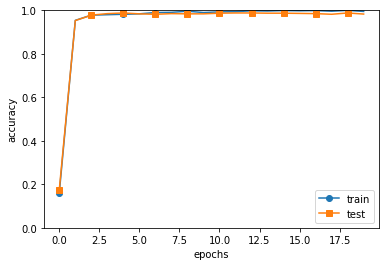

In [13]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# CNNの可視化
畳み込み層を可視化することによってCNNが内部で何を行っているのかを観察する。

## 1層目の重みの可視化
先ほど行ったMNISTデータセットに対する学習では、フィルターはサイズが5×5でチャンネルは1のものが30個だった。つまり、30枚の5×5画素のグレースケール画像へと可視化できる。これを可視化すると次のようになる。

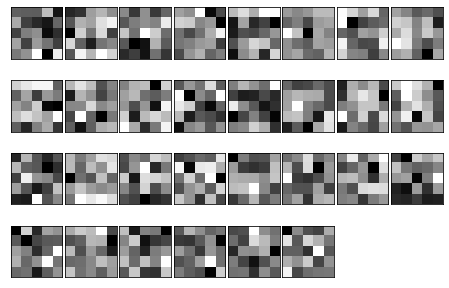

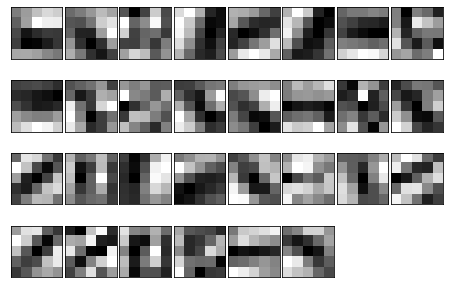

In [14]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

学習前のフィルターはランダムに初期化されているため規則性は見受けられないが、学習後には規則性が見受けられる。学習済みの畳み込み層のフィルターは、エッジやブロブ（塊）などのプリミティブな情報を抽出する。

## 階層構造による情報抽出
CNNでは、層が深くなるにつれて、抽出される情報はより抽象化されていくという研究結果が示されている。

# 代表的なCNN
代表的なCNNとして、1998年に初めて提案されたCNNの元祖、LeNetと、ディープラーニングの火付け役である2012年のAlexNetを紹介する。

## LeNet
LeNetと現在のCNNには、いくつかの違いがある。ひとつめの違いは、活性化関数にある。LeNetではSigmoidが使用されているのに対し、現在では主にReLUが使用されている。また、オリジナルのLeNetではサブサンプリングによって中間データのサイズ縮小を行っているが、現在ではMaxプーリングによるものが主流である。

## AlexNet
AlexNetのLeNetとの違いは、活性化関数がReLUであること、LRN（Local Response Normalization）という局所的正規化を行う層を用いていること、Dropoutを用いていることにある。